In [558]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()


Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=11897011 seed_offset=0 real_seed=11897011
core.init.random: RandomGenerator:ini

In [559]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *
from recces.data import *
from recces.util import *
from rosetta.protocols.rna import *

In [560]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [561]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        if seq2 and ii == (n_residues/2) - 1: continue
            
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})

        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [562]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))

    
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'linmin_iterated', 1e-6, True)
    minmover.max_iter(100000)
    minmover.apply(minimum)
    
    return minimum   

In [563]:
def helix_state(pose, dof_dict):
    
    n_residues = pose.total_residue()
    
    # Definition of helix state backbone torsions
    for ii in range(n_residues - 1):
        
        if ii == n_residues/2 - 1: continue
        
        pose.set_torsion(dof_dict[6*ii], -64.11)
        pose.set_torsion(dof_dict[6*ii+1], 176.33)
        pose.set_torsion(dof_dict[6*ii+2], 53.08)
        pose.set_torsion(dof_dict[6*ii+3], -150.17)
        pose.set_torsion(dof_dict[6*ii+4], -71.45)   
       
    # Definition of helix state chi torsions
    for ii in range(n_residues-1): pose.set_torsion(dof_dict[6*ii+5], 79.43)
    
    return pose

In [564]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            if key > len(dofs)/2 -2: key += 5
            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
            
            if key > len(dofs)/2 - 2: key += 5 
            temp.set_torsion(dof_dict[key], val)
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result

In [565]:
seq1 = 'gg'
seq2 = 'cc'

# Specify local path to where RECCES results are stored
try: 
    hist = SingleHistSimulation('./../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')
    print hist.value - np.log(torsion_volume(seq1, seq2))
except ValueError: pass

n_residues = len(seq1) + len(seq2)

pose, movemap, dof_dict = initialize_pose(seq1, seq2)

scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('/rna/denovo/rna_hires_recces')
scorefxn = rna_hires
#scorefxn.set_weight(core.scoring.lk_nonpolar, 0)
#scorefxn.set_weight(core.scoring.stack_elec, 0)


-12.9781145115


In [493]:
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'dfpmin', 1e-6, False)
minmover.max_iter(1000000)
minmover.min_options().use_nblist(True)
minmover.min_options().nblist_auto_update(True)
#pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [924]:
def wang_landau(K):
    '''Computes the density of states using the Wang-Landau algorithm (see, e.g., )'''
    
    E = lambda x: 0.5*np.dot(K, x**2)
    dr = 0.005
    f = np.exp(1)
    r = np.arange(0,50,dr)
    g = np.zeros_like(r)
    H = np.zeros_like(r)
    x_0 = 0.05*np.ones_like(K)
    print E(x_0)
    
    while f > np.exp(1e-8):
    
        ii = 0
        print f
        while ii < 100000:

            x = np.random.uniform(0, 0.08, (len(K)))
            x_ind = int(E(x)/dr)
            x_0_ind = int(E(x_0)/dr)
            if x_ind > H.shape[0]-1: continue

            if np.log(g[x_ind]) < np.log(g[x_0_ind]) or np.exp(np.log(g[x_ind])-np.log(g[x_0_ind])) < np.random.uniform():


                H[x_ind] += 1
                g[x_ind] += f
                x_0 = x

            else: 

                H[x_0_ind] += 1
                g[x_0_ind] += f
                
            ii += 1

        if H.any < 0.95*np.average(H): continue 

        f = f**0.5
        H = np.zeros_like(r)

    return g, r

In [ ]:
g, r = wang_landau(w)
g = g/max(g)

14.4439948328
2.71828182846


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


1.6487212707
1.28402541669
1.13314845307


-14.2130478289


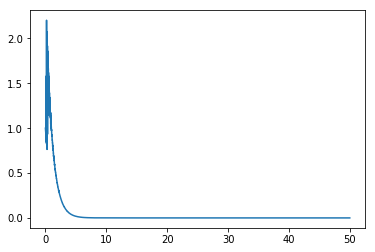

In [897]:
plt.plot(r, np.exp(g)*np.exp(-r))
print -np.log(scipy.special.logsumexp(-(r+scorefxn(minimum)), b=g)) - np.log(torsion_volume(seq1, seq2))

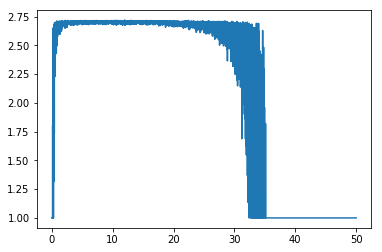

In [898]:
plt.plot(r, np.exp(g))

In [494]:
import itertools

minimum = Pose()

pose.assign(helix_state(pose, dof_dict))
minmover.apply(pose)
minimum.assign(pose)
print scorefxn.show(pose)
h = 0.25
h_rad = h*np.pi/180
E_0 = scorefxn(pose)

dofs = []

for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(2/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-1, 1+h, h)
    
for pair in list(itertools.combinations(dof_dict.keys(), 2)):
    
    foo = pair[0]
    bar = pair[1]
    if foo > len(dofs)/2 - 2: foo -= 5
    if bar > len(dofs)/2 - 2: bar -= 5
    
    x = tor_ranges[:, foo]
    y = tor_ranges[:, bar]

    for ii, xx in enumerate(x):
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[bar])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[foo])
        
    hess = numpy_hessian(energy, h_rad)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[foo, foo] == 0:
        
        hessian[foo, foo] = d2E_dx2[ind, ind]
        
    if hessian[bar, bar] == 0:
        
        hessian[bar, bar] = d2E_dy2[ind, ind]
        
    hessian[foo, bar] = d2E_dxdy[ind, ind]
    hessian[bar, foo] = d2E_dxdy[ind, ind]
    
pose.assign(minimum)

core.scoring: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.730     -30.500     -22.265
 fa_rep                       0.100      18.400       1.840
 fa_intra_rep                 0.007      22.545       0.160
 lk_nonpolar                  0.250      -3.936      -0.984
 fa_elec_rna_phos_phos        4.540       0.000       0.000
 rna_torsion                  4.260       0.155       0.660
 stack_elec                   1.540      -0.304      -0.468
 hbond_sc                     2.460      -8.758     -21.544
---------------------------------------------------
 Total weighted score:                      -42.601
None


In [495]:
import scipy
import scipy.linalg
minimum.dump_pdb('rna_hires_gg_cc.pdb')
w,v = scipy.linalg.eigh(hessian)
print w

[  3.12038867e+00   5.49471639e+00   1.05169424e+01   1.20993030e+01
   1.44682679e+01   2.13807756e+01   2.37344269e+01   5.42965054e+01
   1.76605448e+02   2.46396408e+02   6.81424334e+02   1.60851641e+03
   3.65217619e+03   5.04496575e+03]


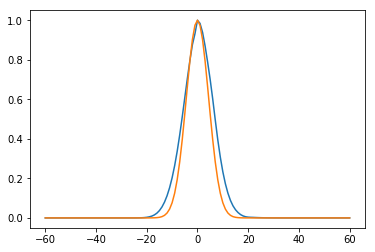

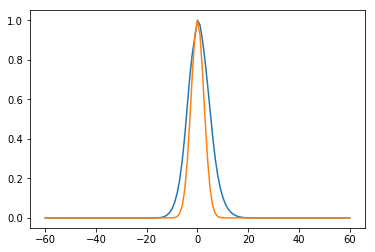

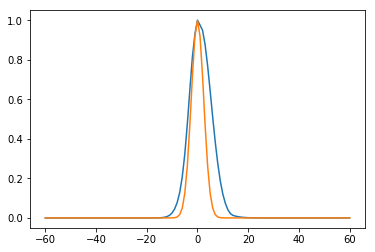

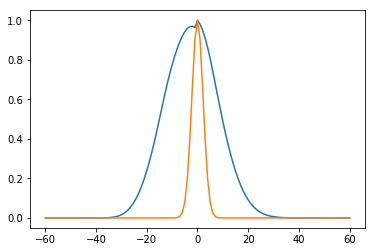

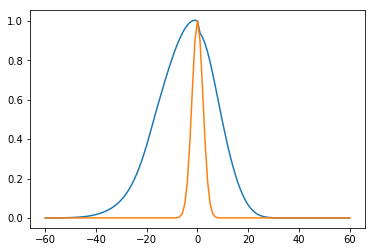

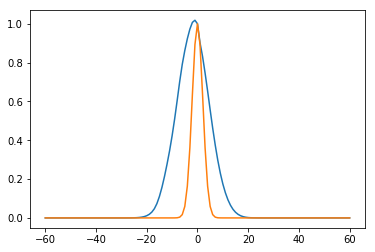

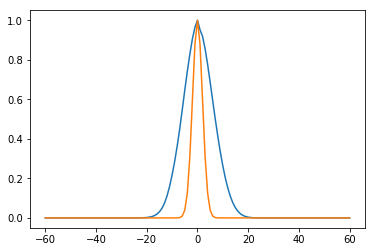

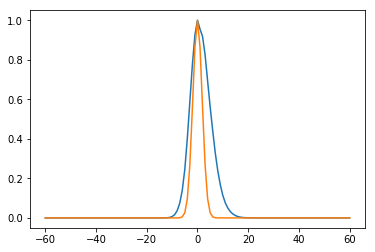

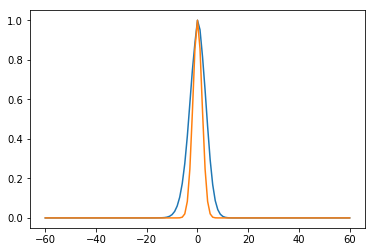

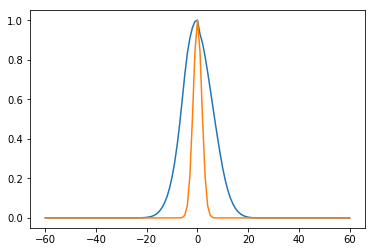

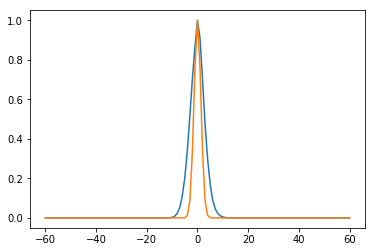

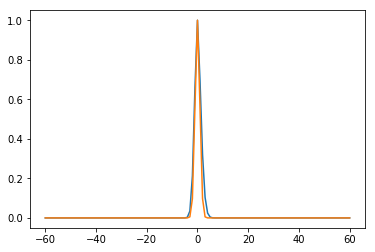

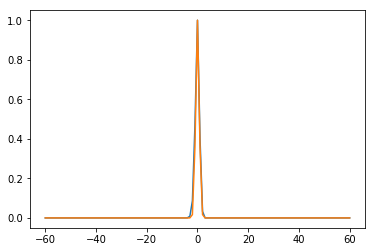

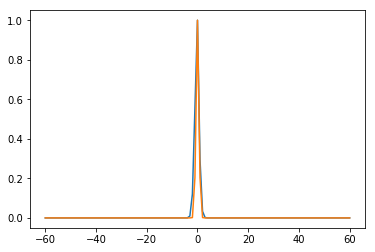

In [471]:
'''this code will assay the normal modes, plotting the corresponding boltzmann weights for both the harmonic approximation
and scanned modes'''

import scipy.integrate

pose.assign(minimum)
kT = 1.0

for kk, K in enumerate(w):
 
    mode = v[:,kk]
    h = np.arange(-60,61,1)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            if jj > len(dofs)/2 - 2: jj += 5
            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_0)/kT)

    np.array(bar) 
    pose.assign(minimum)
    plt.figure()
    #plt.subplot(5, 3, kk+1)
    plt.plot(h, np.exp(-np.array(bar)))
   
    plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    #plt.xlabel('Displacement along normal coordinate (degrees)')
    #plt.ylabel('exp(-(E-E0)/kT)')

In [496]:
'''this code will calculate the configuration integral using both harmonic approximation and mode scanning'''

from scipy.special import *
pose.assign(minimum)
V = 1
kT = 1.0
Z_harm = 1.00
Z_scan = 1.00
for ii, K in enumerate(w):

    # Mode scanning
    Z_j = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,ii], kT, h = 1)
    
    sig = min(2*np.pi/3, 6*np.sqrt(kT/K))
    V*=sig
    # Harmonic approximation
    Z_i = np.sqrt(2.0*np.pi*kT/K)*erf(np.sqrt(2.0*K/kT)*sig/4.0)
    
    Z_harm *= Z_i
    Z_scan *= Z_j
    
    pose.assign(minimum)
    
    print Z_i, Z_j

1.32771505776 0.912111623529
1.054266338 0.739882168457
0.77085216159 0.6287431536
0.718680175027 0.51508392968
0.657215156896 0.703940306062
0.540634945247 0.427478177498
0.513128890555 0.453084648946
0.339257847806 0.294379840351
0.188110827297 0.175647798702
0.159257045971 0.143163735084
0.0957650462818 0.105421803507
0.0623308564497 0.0617732940412
0.0413656622362 0.0396142804183
0.0351954669071 0.0328750458549


In [497]:
print -np.log(Z_harm) + scorefxn(minimum),  -np.log(Z_scan) + scorefxn(minimum) - np.log(torsion_volume(seq1, seq2))

-24.4025055938 -32.8538341707


In [255]:
def partition_function(kT):
    
    Z = 1
    for K in w:
        
        
        sig = np.pi/6
        Z *= math.sqrt(2.0*np.pi/K/kT)*erf(math.sqrt(2.0*kT*K)*sig/4.0)
        
    return Z/((2*np.pi/3)**len(w))

In [256]:
'this code defines an implementation of the Stehfest method for numerically calculating the inverse laplace transform'
import scipy.misc

fact = scipy.misc.factorial

def csteh(n, i):
    acc = 0.0
    for k in xrange(int(np.floor((i+1)/2.0)), int(min(i, n/2.0))+1):
        num = k**(n/2.0) * fact(2 * k)
        den = fact(i - k) * fact(k -1) * fact(k) * fact(2*k - i) * fact(n/2.0 - k)
        acc += (num /den)
    expo = i+n/2.0
    term = np.power(-1+0.0j,expo)
    res = term * acc
    return res.real

def nlinvsteh(t, F=partition_function, n = 18):
    acc = 0.0
    lton2 = np.log(2) / t
    for i in xrange(1, n+1):
        a = csteh(n, i)
        b = F(i * lton2)
        acc += (a * b)
        
    if lton2 * acc > 0.: return lton2 * acc
    else: return 0.

In [257]:
t = np.linspace(0,800,8001)
A = []
for tt in t: A.append(nlinvsteh(tt))
t = np.array(t)
A = np.array(A)
A[A<0.]=0.0


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


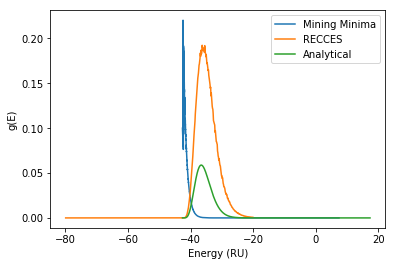

In [900]:
#plt.plot(t[:600]+rna_hires(minimum), 0.15*A[:600]*torsion_volume(seq1, seq2)*np.exp(-t[:600]/1.0)*(np.pi/6)**len(w)*2e14)
plt.plot(r+E_avg, 0.1*np.exp(g)*np.exp(-r))
plt.plot(hist._dos_scores[201:800], hist._dos[201:800]*np.exp(-hist._dos_scores[201:800]/1.0))
plt.plot(t[:600]+rna_hires(minimum), 0.105*matt_guess(E[1000:1600])*np.exp(-(E[1000:1600])/1.0)*(2*np.pi)**len(w))
plt.xlabel('Energy (RU)')
plt.ylabel('g(E)')
plt.legend(('Mining Minima', 'RECCES', 'Analytical'))

In [903]:
bar = scipy.special.logsumexp(-(t+rna_hires(minimum)), b = A)
print bar
print scipy.special.logsumexp(-hist._dos_scores, b = hist._dos)

13.3384409639
2.6284076231


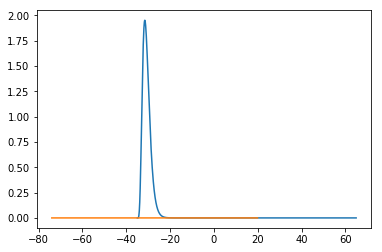

In [260]:
plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000]+scorefxn(minimum))/1.0)*A[:1000]/np.exp(-scorefxn(minimum))*4e14)
plt.plot(hist._dos_scores[260:1200],hist._dos[260:1200]*np.exp(-(hist._dos_scores[260:1200]/1.0)))

In [220]:

print t[100:] + scorefxn(minimum)

[ -63.50038153  -63.40038153  -63.30038153 ...,  726.29961847  726.39961847
  726.49961847]


In [221]:
from recces.util import *
from recces.data import *
curr_wt = [0.73, 0.1, 0.0071, 0, 4.26, 2.46, 0.25, 0, 1.54, 4.54]

In [222]:
E = np.linspace(-100,800,9001)
print t

[  0.00000000e+00   1.00000000e-01   2.00000000e-01 ...,   7.99800000e+02
   7.99900000e+02   8.00000000e+02]


In [852]:




E_avg = rna_hires(minimum)
print E_avg

-42.6010345083


In [264]:
harmonic_dos = lambda E: E**((len(w)/2-1))/math.factorial(len(w)-1)/(np.sqrt((4*np.pi**2)**len(w)/np.linalg.det(hessian)))

In [915]:
matt_guess = lambda E: 2000000*0.0105*(2*np.pi)**((len(w)-1)/2)*(2*E)**(len(w)/2-1)/scipy.misc.factorial2(len(w)-2)/np.sqrt(np.linalg.det(hessian))

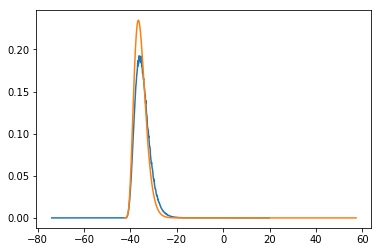

In [881]:
#plt.plot(t[:1000]+rna_hires(minimum),np.exp(-(t[:1000])/1.0)*A[:1000]*1e12)# numerical 
#plt.plot(t[:1000]+E_avg, harmonic_dos(t[:1000])*np.exp(-((t[:1000])/1.00))/torsion_volume(seq1,seq2)*5e17)# harmonic
plt.plot(hist._dos_scores[260:1200], hist._dos[260:1200]*np.exp(-hist._dos_scores[260:1200]/1.0)) # RECCES
plt.plot(E[1000:2000]+E_avg, 2000000*matt_guess(E[1000:2000])*np.exp(-(E[1000:2000])/1.0)*(2*np.pi/3)**len(w)) # Matt's guess for analytical

In [856]:
print hist._dos_scores
dos_scores = np.array(hist._dos_scores)
dos = np.array(hist._dos)

huh = scipy.special.logsumexp(-dos_scores, b=dos)
print hist.value, huh - np.log(torsion_volume(seq1, seq2))

[-100.   -99.9  -99.8 ...,  799.8  799.9  800. ]
-2.6284076231 -7.72129926527


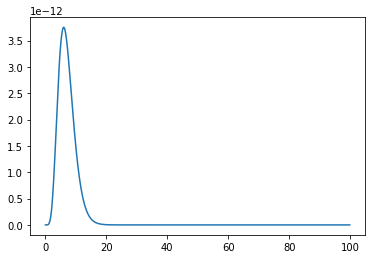

In [846]:
plt.plot(t[:1000], matt_guess(t[:1000])*np.exp(-(t[:1000])/1.0))

In [922]:
bar = scipy.special.logsumexp(-(E-E_avg), b=matt_guess(E))

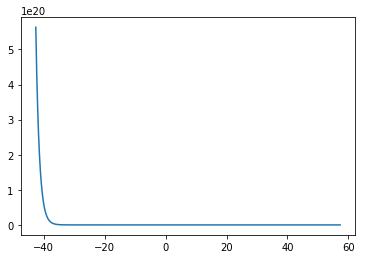

In [871]:
plt.plot(t[:1000]+scorefxn(minimum), harmonic_dos(t[:1000]-E_avg)*np.exp(-(t[:1000]+scorefxn(minimum))))

In [923]:
print bar 
print hist.value - np.log(torsion_volume(seq1, seq2))

70.7760809998
-12.9781145115


In [283]:
print pose.annotated_sequence()

a[RAD:LowerRNA:Virtual_Phosphate]au[URA:Virtual_Phosphate]u[URA:UpperRNA]


In [284]:
pyrosetta.rosetta.protocols.rna.denovo.setup_coarse_chainbreak_constraints(pose, 2)

In [285]:
print pose.annotated_sequence()

a[RAD:LowerRNA:Virtual_Phosphate]au[URA:Virtual_Phosphate]u[URA:UpperRNA]


In [490]:
rna_hires = protocols.rna.denovo.get_rna_hires_scorefxn()
print scorefxn, rna_hires

ScoreFunction::show():
weights: (fa_atr 0.73) (fa_rep 0.1) (fa_intra_rep 0.0071) (lk_nonpolar 0.25) (fa_elec_rna_phos_phos 4.54) (ch_bond 0.42) (rna_torsion 4.26) (rna_sugar_close 0.7) (hbond_sr_bb_sc 0.62) (hbond_lr_bb_sc 3.4) (hbond_sc 2.46) (geom_sol 0.62) (atom_pair_constraint 1)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files: 
EnergyMethodOptions::show: netcharge_setup_files: 
EnergyMethodOptions::show: aspartimide_penalty_value: 25
EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
EnergyMethodOptions::show: exclude_RNA_R

In [491]:
print rna_hires
rna_hires.set_weight(core.scoring.ch_bond, 0.)
rna_hires.set_weight(core.scoring.rna_sugar_close, 0.)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.geom_sol, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
print scorefxn

ScoreFunction::show():
weights: (fa_atr 0.23) (fa_rep 0.12) (fa_intra_rep 0.0029) (lk_nonpolar 0.32) (fa_elec_rna_phos_phos 1.05) (ch_bond 0.42) (rna_torsion 0.1) (rna_sugar_close 0.7) (hbond_sr_bb_sc 0.62) (hbond_lr_bb_sc 3.4) (hbond_sc 3.4) (geom_sol 0.62) (atom_pair_constraint 1)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files: 
EnergyMethodOptions::show: netcharge_setup_files: 
EnergyMethodOptions::show: aspartimide_penalty_value: 25
EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
EnergyMethodOptions::show: exclude_RNA_RN

In [78]:
print scorefxn.set_energy_method_options(core.scoring.methods.WaterAdductHBondEnergy)

TypeError: set_energy_method_options(): incompatible function arguments. The following argument types are supported:
    1. (self: pyrosetta.rosetta.core.scoring.ScoreFunction, energy_method_options_in: core::scoring::methods::EnergyMethodOptions) -> None

Invoked with: <pyrosetta.rosetta.core.scoring.ScoreFunction object at 0x7fb1acee7880>

In [556]:
'''this code approximates the density of states by rnadomly sampling from the proposed energy function'''

def approx_energy(K):
    
    E = 0.
    
    for ii, k in enumerate(K):
        E += k*np.random.uniform(0,0.05)**2/2
    
    if E > 800.0: return E
    else: return E
    
energies = []

for ii in range(int(1e5)):
    
    energies.append(approx_energy(w))
    
print energies
energies = energies[energies < 400]
print energies

[3.0060910451223624, 3.2489065333553184, 3.1316328173944341, 5.9382883339642598, 2.6683739793002337, 4.854086432966346, 5.6608481873203038, 4.44480658875489, 9.2904060003255502, 2.3209858971478958, 6.1445922032786164, 5.0235884647593405, 3.486186831094586, 7.6295438256271773, 8.7470367567541061, 3.6208405020457297, 1.6387839848796295, 0.92120446053286742, 1.3538076089863782, 3.2499591540367536, 0.76869175138668222, 3.8570619136286437, 5.3835112469509223, 3.4167094715240811, 8.6879957806112262, 4.7312269892784222, 4.9599078665131762, 7.3218449906611651, 5.7598939784666667, 2.6004429364399653, 8.6233279870364399, 6.3642726660205469, 4.3108350235421176, 8.0758727799756187, 10.970096809932713, 3.8939470557110774, 5.7740076411543253, 0.96924860189942175, 4.2107139825229609, 6.2974835105323042, 5.4027914525503036, 6.8524946754980478, 3.1732333917356721, 4.4528371880048399, 4.3885340069949414, 8.2168235411439952, 5.1829124817871417, 2.3127123342801914, 1.8299793123725503, 7.2227500198983794, 

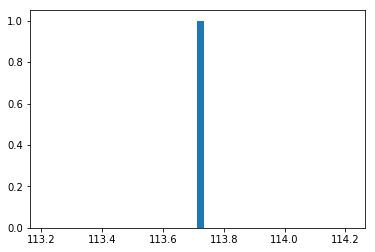

In [551]:
(n, bins, patches) = plt.hist(energies, 50)

In [543]:
print bins

[   3.19513357    9.83190219   16.46867081   23.10543943   29.74220805
   36.37897666   43.01574528   49.6525139    56.28928252   62.92605114
   69.56281976   76.19958838   82.836357     89.47312562   96.10989424
  102.74666286  109.38343148  116.0202001   122.65696872  129.29373734
  135.93050596  142.56727458  149.20404319  155.84081181  162.47758043
  169.11434905  175.75111767  182.38788629  189.02465491  195.66142353
  202.29819215  208.93496077  215.57172939  222.20849801  228.84526663
  235.48203525  242.11880387  248.75557249  255.39234111  262.02910972
  268.66587834  275.30264696  281.93941558  288.5761842   295.21295282
  301.84972144  308.48649006  315.12325868  321.7600273   328.39679592
  335.03356454]


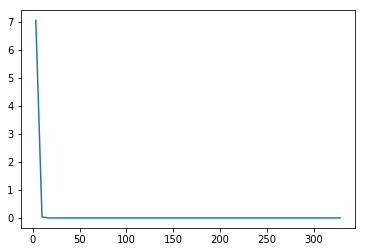

In [544]:
plt.plot(bins[:-1], n*np.exp(-bins[:-1]))